**Goals**

The goal of this notebook is to create KNN and MICE imputation functions or pipe-able classes that we can use as part of our model generation.

In [1]:
import pandas as pd
import numpy as np

**Loading the Data**

For the purpose of developing our model(s), we'll work with data that include the imputed outcome (PCIAT_Total and/or sii) scores AND have cleaned predictors.

In the final version of our code, we'll work with data with cleaned predictors but won't have any access to the outcome scores.

In [2]:
#Load the cleaned & predictor-imputed data
train_cleaned=pd.read_csv('train_cleaned_outcome_imputed.csv')

**Using KNN to Impute Values of Predictor Variables**

Our first code chunk will use a KNN algorithm with all available predictor columns, excluding the Zone and Season columns

We'll start by making a list of quantitative predictor variables. Note that:
* The Zone variables are computed from others; we'll re-compute their values after doing imputation
* The list includes Basic_Demos-Sex. Although this is categorical, all participants have data for this variable, and it's useful for imputing other variables
* We *could* convert the Season variables into dummy variables, but this seems like it would over-weight them for KNN imputation. So we're leaving them out.

Then, we'll construct and use a KNN imputer with 5 neighbors to impute missing values.

We'll wrapp all of this inside a custom imputer that can be called inside a pipe.

In [13]:
## We'll need these
from sklearn.impute import KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler


## Define our custom imputer
class Custom_KNN_Imputer(BaseEstimator, TransformerMixin):
    # Class Constructor 
    # This allows you to initiate the class when you call Custom_KNN_Imputer
    def __init__(self):
        # I want to initiate each object with both a KNNImputer and StandardScaler object/method
        self.KNNImputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
        self.StandardScaler = StandardScaler()

    
    # For my fit method I'm just going to "steal" KNNImputers's fit method using a curated collection of predictors
    def fit(self, X, y = None ):
        feature_list = X.columns.tolist()
        if 'id' in feature_list:
            feature_list.remove('id')
        if 'sii' in feature_list:
            feature_list.remove('sii')
        feature_list = [x for x in feature_list if 'PCIAT' not in x]
        feature_list = [x for x in feature_list if 'Zone' not in x]
        feature_list = [x for x in feature_list if 'Season' not in x]
        self.StandardScaler.fit(X[feature_list])
        # I'm never sure if we need the .values and/or .reshape(-1,1)
        #self.KNNImputer.fit(X[feature_list].values.reshape(-1,1))
        self.KNNImputer.fit(X[feature_list])
        return self
    
    # Now I want to transform the columns in feature list and return it with imputed values that have been un-transformed
    def transform(self, X, y = None):
        feature_list = X.columns.tolist()
        if 'id' in feature_list:
            feature_list.remove('id')
        if 'sii' in feature_list:
            feature_list.remove('sii')
        feature_list = [x for x in feature_list if 'PCIAT' not in x]
        feature_list = [x for x in feature_list if 'Zone' not in x]
        feature_list = [x for x in feature_list if 'Season' not in x]
        copy_X = X.copy()
        copy_X[feature_list] = self.KNNImputer.transform(copy_X[feature_list])
        copy_X2 = self.StandardScaler.inverse_transform(copy_X[feature_list])
        df2 = pd.DataFrame(copy_X2, columns=feature_list)
        copy_X[feature_list]=copy_X[feature_list].fillna(df2[feature_list])
        return copy_X

**A Custom MICE Imputer**

Next, we'll try to take the above code and turn it into a custom imputer that can be used inside a pipe

In [4]:
## We'll need these
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.base import BaseEstimator, TransformerMixin


## Define our custom imputer
class Custom_MICE_Imputer(BaseEstimator, TransformerMixin):
    # Class Constructor 
    # This allows you to initiate the class when you call Custom_KNN_Imputer
    def __init__(self):
        # I want to initiate each object with both a KNNImputer and StandardScaler object/method
        self.MICEImputer = IterativeImputer(max_iter=10, random_state=497)

    
    # For my fit method I'm just going to "steal" IterativeImputers's fit method using a curated collection of predictors
    def fit(self, X, y = None ):
        feature_list = X.columns.tolist()
        if 'id' in feature_list:
            feature_list.remove('id')
        if 'sii' in feature_list:
            feature_list.remove('sii')
        feature_list = [x for x in feature_list if 'PCIAT' not in x]
        feature_list = [x for x in feature_list if 'Zone' not in x]
        feature_list = [x for x in feature_list if 'Season' not in x]
        self.MICEImputer.fit(X[feature_list])
        return self
    
    # Now I want to transform the columns in feature list and return it with imputed values that have been un-transformed
    def transform(self, X, y = None):
        feature_list = X.columns.tolist()
        if 'id' in feature_list:
            feature_list.remove('id')
        if 'sii' in feature_list:
            feature_list.remove('sii')
        feature_list = [x for x in feature_list if 'PCIAT' not in x]
        feature_list = [x for x in feature_list if 'Zone' not in x]
        feature_list = [x for x in feature_list if 'Season' not in x]
        copy_X = X.copy()
        df2 = self.MICEImputer.transform(copy_X[feature_list])
        df3 = pd.DataFrame(df2, columns=feature_list)
        copy_X[feature_list]=copy_X[feature_list].fillna(df3[feature_list])
        return copy_X

**Computing Zone Values**

In this section, we'll create functions that compute the FGC Zone and PAQ_Zone values from the corresponding FGC raw and PAQ_Total (imputed) scores

FitnessGram Healthy Fitness Zones are documented at https://pftdata.org/files/hfz-standards.pdf for:
* FGC-FGC_CU_Zone
* FGC-FGC_PU_Zone
* FGC-FGC_TL_Zone
* FGC-FGC_SR_Zone

FitnessGram Grip Strength Zones appear to be documented at https://www.topendsports.com/testing/norms/handgrip.htm. However, these zones are only defined for ages 10 and up. And it appears that no participants under the age of 10 had their grip strength measured. So maybe it doesn't make sense to include this predictor at all?

For the PAQ numbers, some research (https://pubmed.ncbi.nlm.nih.gov/27759968/) has identified a cut-off score of 2.75 (ages 14-20) and 2.73 (ages 8-14) to discriminate >60 minutes of MVPA. However, the study suggests that, while the cutoff is significant for the older group, it isn't for for the younger.


In [5]:
# Compute values for the 'FGC-FGC_SR_Zone' that is equal to 1 if any of the following are true:
# Basic_Demos-Sex==0 and FGC-FGC_SR >= 8
# Basic_Demos-Sex==1 and FGC-FGC_SR >= 9 and Basic_Demos-Age is between 5 and 10
# Basic_Demos-Sex==1 and FGC-FGC_SR >= 10 and Basic_Demos-Age is between 11 and 14
# Basic_Demos-Sex==1 and FGC-FGC_SR >= 12 and Basic_Demos-Age is at least 15
# Note that Basic_Demos-Sex is coded as 0=Male and 1=Female

def sitreachzone(sex, age, sr):
    try:
        if np.isnan(sr) or np.isnan(sex) or np.isnan(age):
            return np.nan
        elif sex == 0 and sr>=8:
            return 1
        elif sex == 1 and age >= 15 and sr >= 12:
            return 1
        elif sex == 1 and age >= 11 and sr >= 10:
            return 1
        elif sex == 1 and age >= 5 and sr >= 9:
            return 1
        else:
            return 0
    except:
        return np.nan

In [6]:
# Compute values for the 'FGC-FGC_CU_Zone' that is equal to 1 if any of the following are true:
# Basic_Demos-Sex==0 and FGC-FGC_CU >= 2 and Basic_Demos-Age is between 5 and 6
# Basic_Demos-Sex==0 and FGC-FGC_CU >= 4 and Basic_Demos-Age is 7
# Basic_Demos-Sex==0 and FGC-FGC_CU >= 6 and Basic_Demos-Age is 8
# Basic_Demos-Sex==0 and FGC-FGC_CU >= 9 and Basic_Demos-Age is 9
# Basic_Demos-Sex==0 and FGC-FGC_CU >= 12 and Basic_Demos-Age is 10
# Basic_Demos-Sex==0 and FGC-FGC_CU >= 15 and Basic_Demos-Age is 11
# Basic_Demos-Sex==0 and FGC-FGC_CU >= 18 and Basic_Demos-Age is 12
# Basic_Demos-Sex==0 and FGC-FGC_CU >= 21 and Basic_Demos-Age is 13
# Basic_Demos-Sex==0 and FGC-FGC_CU >= 24 and Basic_Demos-Age is at least 14
# Basic_Demos-Sex==1 and FGC-FGC_CU >= 2 and Basic_Demos-Age is between 5 and 6
# Basic_Demos-Sex==1 and FGC-FGC_CU >= 4 and Basic_Demos-Age is 7
# Basic_Demos-Sex==1 and FGC-FGC_CU >= 6 and Basic_Demos-Age is 8
# Basic_Demos-Sex==1 and FGC-FGC_CU >= 9 and Basic_Demos-Age is 9
# Basic_Demos-Sex==1 and FGC-FGC_CU >= 12 and Basic_Demos-Age is 10
# Basic_Demos-Sex==1 and FGC-FGC_CU >= 15 and Basic_Demos-Age is 11
# Basic_Demos-Sex==1 and FGC-FGC_CU >= 18 and Basic_Demos-Age is at least 12

def curlupzone(sex, age, cu):
    try:
        if np.isnan(sex) or np.isnan(age) or np.isnan(cu):
            return np.nan
        elif sex == 0:
            if (age >= 14 and cu >= 24) or (age == 13 and cu >= 21) or (age == 12 and cu >= 18) or (age == 11 and cu >= 15) or (age == 10 and cu >= 12) or (age == 9 and cu >= 9) or (age == 8 and cu >= 6) or (age == 7 and cu >= 4) or (age <= 6 and cu >= 2):
                return 1
        elif sex == 1:
            if (age >= 12 and cu >= 18) or (age == 11 and cu >= 15) or (age == 10 and cu >= 12) or (age == 9 and cu >= 9) or (age == 8 and cu >= 6) or (age == 7 and cu >= 4) or (age <= 6 and cu >= 2):
                return 1
        else:
                return 0
    except:
        return np.nan

In [7]:
# Compute values for the 'FGC-FGC_PU_Zone' that is equal to 1 if any of the following are true:
# Basic_Demos-Sex==0 and FGC-FGC_PU >= 3 and Basic_Demos-Age is between 5 and 6
# Basic_Demos-Sex==0 and FGC-FGC_PU >= 4 and Basic_Demos-Age is 7
# Basic_Demos-Sex==0 and FGC-FGC_PU >= 5 and Basic_Demos-Age is 8
# Basic_Demos-Sex==0 and FGC-FGC_PU >= 6 and Basic_Demos-Age is 9
# Basic_Demos-Sex==0 and FGC-FGC_PU >= 7 and Basic_Demos-Age is 10
# Basic_Demos-Sex==0 and FGC-FGC_PU >= 8 and Basic_Demos-Age is 11
# Basic_Demos-Sex==0 and FGC-FGC_PU >= 10 and Basic_Demos-Age is 12
# Basic_Demos-Sex==0 and FGC-FGC_PU >= 12 and Basic_Demos-Age is 13
# Basic_Demos-Sex==0 and FGC-FGC_PU >= 14 and Basic_Demos-Age is 14
# Basic_Demos-Sex==0 and FGC-FGC_PU >= 16 and Basic_Demos-Age is 15
# Basic_Demos-Sex==0 and FGC-FGC_PU >= 18 and Basic_Demos-Age is at least 16
# Basic_Demos-Sex==1 and FGC-FGC_PU >= 3 and Basic_Demos-Age is between 5 and 6
# Basic_Demos-Sex==1 and FGC-FGC_PU >= 4 and Basic_Demos-Age is 7
# Basic_Demos-Sex==1 and FGC-FGC_PU >= 5 and Basic_Demos-Age is 8
# Basic_Demos-Sex==1 and FGC-FGC_PU >= 6 and Basic_Demos-Age is 9
# Basic_Demos-Sex==1 and FGC-FGC_PU >= 7 and Basic_Demos-Age is at least 10

def pullupzone(sex, age, pu):
    try:
        if np.isnan(sex) or np.isnan(age) or np.isnan(pu):
            return np.nan
        elif sex == 0:
            if (age >= 16 and pu >= 18) or (age == 15 and pu >= 16) or (age == 14 and pu >= 14) or (age == 13 and pu >= 12) or (age == 12 and pu >= 10) or (age == 11 and pu >= 8) or (age == 10 and pu >= 7) or (age == 9 and pu >= 6) or (age == 8 and pu >= 5) or (age == 7 and pu >= 4) or (age <= 6 and pu >= 2):
                return 1
        elif sex == 1:
            if (age >= 10 and pu >= 7) or (age == 9 and pu >= 6) or (age == 8 and pu >= 5) or (age == 7 and pu >= 4) or (age <= 6 and pu >= 3):
                return 1
        else:
            return 0
    except:
        return np.nan

In [8]:
# Comtlte values for the 'FGC-FGC_TL_Zone' that is equal to 1 if any of the following are true:
# FGC-FGC_TL >= 6 and Basic_Demos-Age is between 5 and 9
# FGC-FGC_TL >= 9 and Basic_Demos-Age is at least 10

def tlzone(age, tl):
    try:
        if np.isnan(tl) or np.isnan(age):
            return np.nan
        elif (age >= 10 and tl >= 9) or (age <= 9 and tl >= 6):
            return 1
        else:
            return 0
    except:
        return np.nan

In [9]:
# Comtlte values for the 'PAQ_MVPA' that is equal to 1 if any of the following are true:
# PAQ_Total >= 2.73 and Basic_Demos-Age is between 5 and 13
# PAQ_Total >= 2.75 and Basic_Demos-Age is at least 14

def paqzone(age, paq):
    try:
        if np.isnan(paq) or np.isnan(age):
            return np.nan
        elif (age >= 14 and paq >= 2.75) or (age <= 13 and paq >= 2.73):
            return 1
        else:
            return 0
    except:
        return np.nan

**A Custom Encoder for Zone Variables**

The goal of this next section is to define a function that will take in a dataframe and return one with the codes for the Zone variables based on the functions defined above

It's possible that the dataframe might lack and age, sex, or one of the raw "score" variables that we'd use to do this encoding, so the encoder will need to check for the presence of these variables.

Below are two versions of the function. The first one will raise a ValueError if one of the necessary input variables is missing. The second will fill missing values with the mean of the already-present values. (This is a very naive imputation method and we could improve it if we thought that the Zone variables might be important predictors)

In [10]:
def zone_encoder_halting(df):
    df_copy = df.copy()

    # first check to see if age and sex are among the columns of df_copy
    if 'Basic_Demos-Age' not in df_copy.columns or 'Basic_Demos-Sex' not in df_copy.columns:
        raise ValueError('Basic_Demos-Age and Basic_Demos-Sex not present')
    else:
        # Check to see if FGC-FGC_SR_Zone is in the columns of df_copy
        if 'FGC-FGC_SR_Zone' in df_copy.columns:
            # check to see if GC-FGC_SR is in the columns of df_copy
            if 'FGC-FGC_SR' in df_copy.columns:
                df_copy['FGC-FGC_SR_Zone'] = df_copy.apply(lambda x: sitreachzone(x['Basic_Demos-Sex'], x['Basic_Demos-Age'], x['FGC-FGC_SR']), axis=1)
            else: 
                raise ValueError('FGC-FGC_SR_Zone is a predictor but FGC-FGC_SR is missing')
        if 'FGC-FGC_CU_Zone' in df_copy.columns:
            if 'FGC-FGC_CU' in df_copy.columns:
                df_copy['FGC-FGC_CU_Zone'] = df_copy.apply(lambda x: curlupzone(x['Basic_Demos-Sex'], x['Basic_Demos-Age'], x['FGC-FGC_CU']), axis=1)
            else:
                raise ValueError('FGC-FGC_CU_Zone is a predictor but FGC-FGC_CU is missing')
        if 'FGC-FGC_PU_Zone' in df_copy.columns:
            if 'FGC-FGC_PU' in df_copy.columns:
                df_copy['FGC-FGC_PU_Zone'] = df_copy.apply(lambda x: pullupzone(x['Basic_Demos-Sex'], x['Basic_Demos-Age'], x['FGC-FGC_PU']), axis=1)
            else:
                raise ValueError('FGC-FGC_PU_Zone is a predictor but FGC-FGC_PU is missing') 
        if 'FGC-FGC_TL_Zone' in df_copy.columns:
            if 'FGC-FGC_TL' in df_copy.columns:
                df_copy['FGC-FGC_TL_Zone'] = df_copy.apply(lambda x: tlzone(x['Basic_Demos-Age'], x['FGC-FGC_TL']), axis=1)
            else:
                raise ValueError('FGC-FGC_TL_Zone is a predictor but FGC-FGC_TL is missing') 
        if 'PAQ_Zone' in df_copy.columns:
            if 'PAQ_Total' in df_copy.columns:
                df_copy['PAQ_Zone'] = df_copy.apply(lambda x: paqzone(x['Basic_Demos-Age'], x['PAQ_Total']), axis=1)
            else:
                raise ValueError('PAQ_Zone is a predictor but PAQ_Total is missing')
        return df_copy

In [11]:
def zone_encoder(df):
    df_copy = df.copy()

    if 'FGC-FGC_SR_Zone' in df_copy.columns:
        if 'Basic_Demos-Age' in df_copy.columns and 'Basic_Demos-Sex' in df_copy.columns and 'FGC-FGC_SR' in df_copy.columns:
            df_copy['FGC-FGC_SR_Zone'] = df_copy.apply(lambda x: sitreachzone(x['Basic_Demos-Sex'], x['Basic_Demos-Age'], x['FGC-FGC_SR']), axis=1)
        else:
            df_copy['FGC-FGC_SR_Zone'] = df_copy['FGC-FGC_SR_Zone'].fillna(df_copy['FGC-FGC_SR_Zone'].mean())
    if 'FGC-FGC_CU_Zone' in df_copy.columns:
        if 'Basic_Demos-Age' in df_copy.columns and 'Basic_Demos-Sex' in df_copy.columns and 'FGC-FGC_CU' in df_copy.columns:
            df_copy['FGC-FGC_CU_Zone'] = df_copy.apply(lambda x: curlupzone(x['Basic_Demos-Sex'], x['Basic_Demos-Age'], x['FGC-FGC_CU']), axis=1)
        else:
            df_copy['FGC-FGC_CU_Zone'] = df_copy['FGC-FGC_CU_Zone'].fillna(df_copy['FGC-FGC_CU_Zone'].mean())
    if 'FGC-FGC_PU_Zone' in df_copy.columns:
        if 'Basic_Demos-Age' in df_copy.columns and 'Basic_Demos-Sex' in df_copy.columns and 'FGC-FGC_PU' in df_copy.columns:
            df_copy['FGC-FGC_PU_Zone'] = df_copy.apply(lambda x: curlupzone(x['Basic_Demos-Sex'], x['Basic_Demos-Age'], x['FGC-FGC_PU']), axis=1)
        else:
            df_copy['FGC-FGC_PU_Zone'] = df_copy['FGC-FGC_PU_Zone'].fillna(df_copy['FGC-FGC_PU_Zone'].mean())
    if 'FGC-FGC_TL_Zone' in df_copy.columns:
        if 'Basic_Demos-Age' in df_copy.columns and 'FGC-FGC_PU' in df_copy.columns:
            df_copy['FGC-FGC_TL_Zone'] = df_copy.apply(lambda x: tlzone(x['Basic_Demos-Age'], x['FGC-FGC_TL']), axis=1)
        else:
            df_copy['FGC-FGC_TL_Zone'] = df_copy['FGC-FGC_TL_Zone'].fillna(df_copy['FGC-FGC_TL_Zone'].mean())
    if 'PAQ_Zone' in df_copy.columns:
        if 'Basic_Demos-Age' in df_copy.columns and 'PAQ_Total' in df_copy.columns:
            df_copy['PAQ_Zone'] = df_copy.apply(lambda x: tlzone(x['Basic_Demos-Age'], x['PAQ_Total']), axis=1)
        else:
            df_copy['PAQ_Zone'] = df_copy.apply(lambda x: paqzone(x['Basic_Demos-Age'], x['PAQ_Total']), axis=1)
    return df_copy

**Creating a Pipeline with the Custom Imputer and Transformer**

Below is some code that is based on the 2_More_Advanced_Pipelines notebook from optional_extra_practice in Week 3

In that code, their desired pipeline was:
1 Impute the missing values of `body_mass_g` with the `median` value,
2 Impute the missing values of `sex` with the most common value,
3 One hot encode `island` and `sex` and
4 Fit a random forest model to the data.

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import FunctionTransformer


predictors = train_cleaned.columns.tolist()
if 'id' in predictors:
    predictors.remove('id')
if 'sii' in predictors:
    predictors.remove('sii')
predictors = [x for x in predictors if 'PCIAT' not in x]
predictors = [x for x in predictors if 'Season' not in x]


pipe_knn = Pipeline([('knn_impute', Custom_KNN_Imputer()),
                    ('add_zones', FunctionTransformer(zone_encoder)),
                    ('rf', RandomForestRegressor(n_estimators = 300, max_features = 'sqrt', max_depth = 5, random_state = 216))])

pipe_knn.fit(train_cleaned[predictors],train_cleaned['PCIAT-PCIAT_Total'])

train_pred_knn = pipe_knn.predict(train_cleaned[predictors])



pipe_mice = Pipeline([('mice_impute', Custom_MICE_Imputer()),
                    ('add_zones', FunctionTransformer(zone_encoder)),
                    ('rf', RandomForestRegressor(n_estimators = 300, max_features = 'sqrt', max_depth = 5, random_state = 216))])

pipe_mice.fit(train_cleaned[predictors],train_cleaned['PCIAT-PCIAT_Total'])

train_pred_mice = pipe_mice.predict(train_cleaned[predictors])


In [18]:
train_pred_knn

array([20.15264468, 39.05305617, 21.29305395, ..., 23.00004803,
       42.60562648, 13.31095219])

In [15]:
# Compare predictions with the actual values
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print('KNN Imputation RMSE: ', np.sqrt(mean_squared_error(train_cleaned['PCIAT-PCIAT_Total'], train_pred_knn)))
print('KNN Imputation R2: ', r2_score(train_cleaned['PCIAT-PCIAT_Total'], train_pred_knn))

print('MICE Imputation RMSE: ', np.sqrt(mean_squared_error(train_cleaned['PCIAT-PCIAT_Total'], train_pred_mice)))
print('MICE Imputation R2: ', r2_score(train_cleaned['PCIAT-PCIAT_Total'], train_pred_mice))


KNN Imputation RMSE:  16.36115582577966
KNN Imputation R2:  0.35590456246871194
MICE Imputation RMSE:  16.29080143310043
MICE Imputation R2:  0.36143198543542643


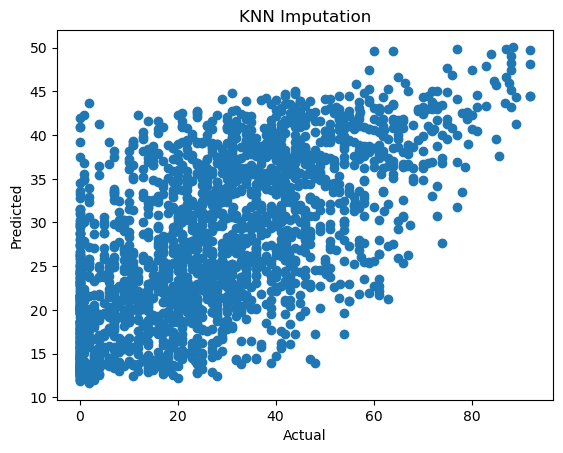

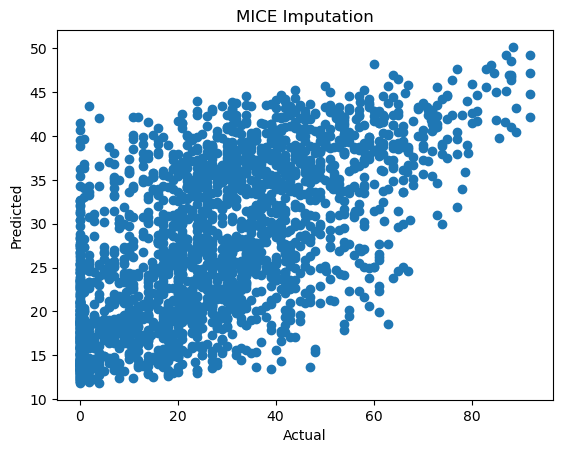

In [17]:
# Plot actual vs predicted values
import matplotlib.pyplot as plt

plt.scatter(train_cleaned['PCIAT-PCIAT_Total'], train_pred_knn)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('KNN Imputation')
plt.show()

plt.scatter(train_cleaned['PCIAT-PCIAT_Total'], train_pred_mice)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('MICE Imputation')
plt.show()

In [19]:
#Now we can calculate a new sii score with the imputed values. 
bins = [0, 30, 49,79,100]
labels = [0,1,2,3]
train_pred_knn_sii = pd.cut(train_pred_knn, bins=bins, labels=labels, right=False)

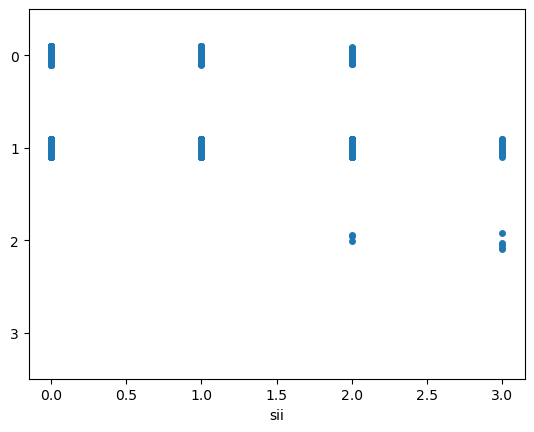

In [28]:
# Plot actual sii values vs train_pred_knn_sii with jitter
import seaborn as sns
sns.stripplot(x=train_cleaned['sii'], y=train_pred_knn_sii, jitter=True)
plt.show()

In [29]:
# import random forest classifier
from sklearn.ensemble import RandomForestClassifier

In [30]:
pipe_knn_classifier = Pipeline([('knn_impute', Custom_KNN_Imputer()),
                    ('add_zones', FunctionTransformer(zone_encoder)),
                    ('rf', RandomForestClassifier(n_estimators = 300, max_features = 'sqrt', max_depth = 5, random_state = 216))])

pipe_knn_classifier.fit(train_cleaned[predictors],train_cleaned['sii'])

train_pred_knn_classifier = pipe_knn_classifier.predict(train_cleaned[predictors])

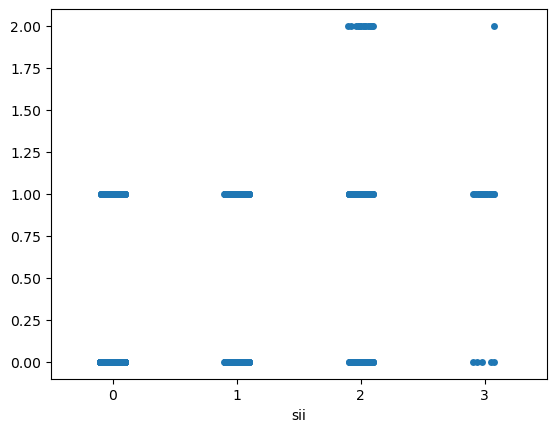

In [32]:
# Plot actual sii values vs train_pred_knn_sii with jitter
import seaborn as sns
sns.stripplot(x=train_cleaned['sii'], y=train_pred_knn_classifier, jitter=True)
plt.show()

In [24]:
#Get feature importance from the rf inside pipe
score_knn_df = pd.DataFrame({'feature':train_cleaned[predictors].columns,
                            'importance_score': pipe_knn.named_steps['rf'].feature_importances_})

score_knn_df.sort_values('importance_score',ascending=False)

,feature,importance_score
4,Physical-Height,0.138206
0,Basic_Demos-Age,0.128269
24,PreInt_EduHx-computerinternet_hoursday,0.122673
5,Physical-Weight,0.088061
23,SDS-SDS_Total_Raw,0.072821
18,BIA-BIA_FFM,0.070766
11,FGC-FGC_CU,0.062064
6,Physical-Waist_Circumference,0.036682
21,BIA-BIA_Fat,0.029994
19,BIA-BIA_FFMI,0.026096


In [25]:
#Get feature importance from the rf inside pipe
score_mice_df = pd.DataFrame({'feature':train_cleaned[predictors].columns,
                            'importance_score': pipe_mice.named_steps['rf'].feature_importances_})

score_mice_df.sort_values('importance_score',ascending=False)

,feature,importance_score
4,Physical-Height,0.137001
0,Basic_Demos-Age,0.124362
24,PreInt_EduHx-computerinternet_hoursday,0.123129
18,BIA-BIA_FFM,0.076854
5,Physical-Weight,0.073994
23,SDS-SDS_Total_Raw,0.073693
11,FGC-FGC_CU,0.062461
26,ENMO_Avg_Active_Days_MVPA110,0.058113
21,BIA-BIA_Fat,0.026684
19,BIA-BIA_FFMI,0.022597
